In [18]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
import time
import math
import scipy.stats

# Discrete Time Markov Chains - Part 2
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC simulation before attempting to solve it!
In order to complete this notebook, you need the models implemented in Part 1 notebook on DTMC.

In [19]:
#Some useful methods from the lecture on Sampling

def sample_from_uniform(N):
    
    uniform_samples = np.random.uniform(low=0.0, high=1.0, size=N)
    
    return uniform_samples

def sample_discrete(N,p):
    n = p.shape[0]
    epsilon = 0.001
    if  (np.sum(p) > (1.0 + epsilon) or np.sum(p) < (1 - epsilon)):
        print("Watch out: the vector of probabilities do not sum up to one!")
    else:
        S = np.cumsum(p)
        U = sample_from_uniform(N)
    
        sampled_indexes = np.empty(N)
        for j in range(N):
            for i in range(n):
                if S[i] > U[j]:
                    sampled_indexes[j] = i
                    break

        return sampled_indexes

### 1. Simulation of DTMC
Write a method that simulates a DTMC for `n` steps, where `n` is a parameter of the method, and returns the whole trajectory as output.

In [20]:
#The class of the previous homework is reused, with a difference on the method get_prob_model (see comment above)
#and a new method for the simulation

class DTCM:
    """A class to initialize a DTMC, to compute transient bdtcm.simulate_DTMC(n)ehaviour, steady state behaviour, and reachability"""
    
    def __init__(self, trans_matrix, init_prob):
        self.check_well_defined(trans_matrix)
        self.trans_matrix = trans_matrix
        self.init_prob = init_prob
        self.state_names = None

    def check_well_defined(self, trans_matrix):
        epsilon = 0.0001
        for i in range(len(trans_matrix)):
            sum_row = 0
            for j in range(len(trans_matrix)):
                sum_row = sum_row + trans_matrix[i][j]
            if(sum_row > (1.0 + epsilon) or sum_row < (1 - epsilon)):
                raise Exception("The transition matrix is not well defined!")
        
        
    #Transient behviour
    def get_prob_model(self, n, create_plot = True, preserve_change = False):
        pi=[]
        pi.append(self.init_prob)
        trans_copy=self.trans_matrix.copy()
        for i in range(n):
            trans_copy=np.matmul(trans_copy,self.trans_matrix)
            prob_model = np.matmul(self.init_prob,trans_copy)
            pi.append(prob_model)
        if(create_plot):
            print(prob_model)
            dfdistribution = pd.DataFrame(pi)
            plt.pcolormesh(dfdistribution)
            plt.show()
            dfdistribution.plot()
            plt.show()
        if(preserve_change):
            #ADDED THE FOLLOWING COMMAND TO PRESERVE THE CHANGES TO THE TRANSITION MATRIX
            self.trans_matrix = trans_copy
        return prob_model

    #steady state behaviour
    def get_steady_state_probability(self):    
        #define an inital state (the steady state behaviour doesn't depend on it)
        p_0 = [0 for i in range(len(self.trans_matrix))]
        p_0[0]=1        
        #compute p_n until the error is smaller than epsilon = 0.01
        p_pre = p_0
        p_after = np.matmul(p_0,self.trans_matrix)
        eps = 0.0001
        count = 0    
        while(np.linalg.norm(p_after-p_pre)>eps and count != 100):
            p_pre = p_after
            p_after = np.matmul(p_after,self.trans_matrix)
            count = count + 1            
        return p_after, count

    #reachability
    def get_prob_absorption_model(self, target_region):
        #STEP 1: modify DTMC to pi_A
        pi_A = self.trans_matrix
        for i in range(len(target_region)):
            index = target_region[i]
            for j in range(len(self.trans_matrix)):
                pi_A[index][j] = 0
            pi_A[index][index] = 1
        #STEP 2: compute h_0
        h_0 = [0 for i in range(len(self.trans_matrix))]
        for i in range(len(target_region)):
            h_0[target_region[i]]=1
        #STEP 3: compute h_n until the error is smaller than epsilon = 0.01
        h_pre = h_0
        h_after = np.matmul(pi_A, h_0)
        eps = 0.01
        count = 0
        h_pre = h_after
        h_after = np.matmul(pi_A,h_after)
        count = count + 1  
        while(np.linalg.norm(h_after-h_pre)>eps and count != 100):
            h_pre = h_after
            h_after = np.matmul(pi_A,h_after)
            count = count + 1            
        return h_after, count
    
    #hitting time
    def get_exp_hitting_time_model(self, target_region):    
        e_0 = [1 for i in range(len(self.trans_matrix))]
        maxcount = 100
        #STEP 1: modify DTMC to pi_A
        pi_A = self.trans_matrix
        for i in range(len(target_region)):
            index = target_region[i]
            for j in range(len(self.trans_matrix)):
                pi_A[index][j] = 0
            pi_A[index][index] = 1
        #STEP 2: compute xi_0
        xi_0 = [1 for i in range(len(self.trans_matrix))]   
        for i in range(len(target_region)):
            xi_0[target_region[i]]=0
        #STEP 3: compute xi_n until the error is smaller than epsilon
        xi_pre = xi_0
        xi_pre= [a + b if a>0 else 0 for a, b in zip(xi_pre, e_0) ] 
        xi_after = np.matmul(pi_A, (xi_pre))
        eps = 0.01
        count = 0
        xi_pre = xi_after
        xi_after= [a + b if a>0 else 0 for a, b in zip(xi_after, e_0) ]
        xi_after = np.matmul(pi_A,(xi_after))
        count = count + 1  
        while(np.linalg.norm(xi_after-xi_pre)>eps and count != maxcount):
            xi_pre = xi_after
            xi_after= [a + b if a>0 else 0 for a, b in zip(xi_after, e_0) ]
            xi_after = np.matmul(pi_A,(xi_after))
            count = count + 1
        if(count == maxcount):
            warnings.warn("The algorithm doesn't converge in " + str(maxcount) + " steps")   
        return xi_after, count
    
    #map linking state numbers to names
    def map_names(self, names):
        state_num = [i for i in range(len(self.trans_matrix))]
        self.state_names = dict(zip(state_num, names))
    
    #simulate a possible trajectory from the probability model
    def simulate_DTMC(self, n, create_plot = True):
        s=[0 for j in range(n)]
        s[0] = sample_discrete(1, self.init_prob)
        for i in range(n-1):
            pi_i = self.get_prob_model(1, False, True)
            s[i+1] = sample_discrete(1, pi_i)
        if(create_plot):
            plt.plot(range(n), s)
            plt.show()
        return s

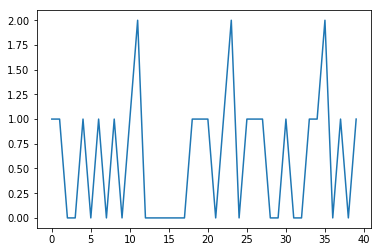

[array([1.]),
 array([1.]),
 array([0.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([2.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([1.]),
 array([2.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([0.]),
 array([1.]),
 array([1.]),
 array([2.]),
 array([0.]),
 array([1.]),
 array([0.]),
 array([1.])]

In [21]:
P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])
init_state=np.array([0.0, 1.0, 0.0])
n = 40

dtcm = DTCM(P, init_state)
dtcm.simulate_DTMC(n)

### 2. Statistical analysis
Write methods for:
- 2.1. computing the average of a function `f` of the state space, at time step `n`.
- 2.2. computing the probability of reaching a target region `A` of the state space by time step `n`.

Both methods should use simulation, and return an estimate and a confidence interval at a specified confidence level `alpha` (0.95% by default).

In [22]:
#Simulate the trajectories m times, compute the function in each trajectory (f_j)
#and calculate E[y] = 1/n * sum(f_j)

def average_function(P, init_state, f, n, confidence = 0.95):
    m = 10
    y_j = []
    for j in range(m):
        dtcm = DTCM(P, init_state)
        t = dtcm.simulate_DTMC(n, False)
        y_j.append(f(t))
    y_n = 1/m*sum(y_j)
    dif = [math.pow(y_j[i]-y_n, 2) for i in range(m)]
    s_n = math.pow(1/(m-1)*sum(dif), 0.5)
    h = s_n / math.pow(m,0.5) * scipy.stats.t.ppf((1 + confidence) / 2., m-1)
    
    
    return y_n, y_n - h, y_n + h

In [23]:
confidence = 0.95
y, int1, int2 = average_function(P, init_state, max, 10, confidence)
print("The average of the function is: " + str(y) + " with confidence interval at level " + str(confidence*100) + "% : [ " + str(int1)+ ", " + str(int2) + " ]")

The average of the function is: [1.5] with confidence interval at level 95.0% : [ [1.12297381], [1.87702619] ]


In [24]:
#Simulate the trajectories m times, compute the number of times A is reached over m (and calculate the interval assuming Bernoulli distribution)

def prob_reach_A(P, init_state, target_region, n, confidence = 0.95):
    m = 100
    y_j = []
    pi_A = P.copy()
    count = 0 
    #the states of the target region are absorbing
    for i in range(len(target_region)):
        index = target_region[i]
        for j in range(len(P)):
            pi_A[index][j] = 0
        pi_A[index][index] = 1
    for j in range(m):
        #this should be optimized not to initialize at each iteration 
        dtcm = DTCM(pi_A, init_state)
        t = dtcm.simulate_DTMC(n, False)
        if(t[n-1] in target_region):
            count = count + 1
    y_n = count/m
    
    s_n = math.pow(y_n*(1-y_n), 0.5)         
    h = s_n / math.pow(n,0.5) * scipy.stats.t.ppf((1 + confidence) / 2., m-1) 
    
    return y_n, y_n - h, y_n + h
    

In [25]:
P = np.array([[1, 0, 0, 0, 0],
              [0.6, 0, 0.4, 0, 0],
              [0, 0.6, 0, 0.4, 0],
              [0, 0, 0.6, 0, 0.4],
              [0, 0, 0, 0, 1]])
init = np.array([0.0, 0.0, 0.0, 1.0, 0.0])
region=np.array([0])
confidence = 0.80
y, int1, int2 = prob_reach_A(P, init, region, 10, confidence)
print("The probability of reaching A is: " + str(y) + " with confidence interval at level " + str(confidence*100) + "% : [ " + str(int1)+ ", " + str(int2) + " ]")

The probability of reaching A is: 0.34 with confidence interval at level 80.0% : [ 0.14673398823555078, 0.5332660117644492 ]


### 3. Branching chain
Consider a population, in which each individual at each
generation independently gives birth to $k$ individuals with
probability $p_k$. These will be the members of the next
generation. Assume $k\in\{-1, 0,1,2\}$. The population is initial compused of two individuals Adam and Eve.

Assume now that $p_0 = p_1 = p_2 = (1-p_{-1})/3$. Estimate the average and the confidence interval of the probability of the population to become extinct for increasing values of $p_{-1}$.

In [27]:
#Simulate for each individual and sum the number of children of all the individuals 
#to get the number of individuals of the next generation

def simulate_branching_chain(n_i, p_i, N, create_plot = True):
    s=[0 for j in range(N+1)]
    s[0] = n_i
    for j in range(N):
        xn = 0
        for i in range(n_i):        
            xi = sample_discrete(1, p_i)
            xn = xn + xi       
        n_i = int(xn)
        s[j+1] = int(xn)
        
    if(create_plot):
        plt.plot(range(N+1), s)
        plt.show()
    return xn

In [28]:
def get_prob_extinction(n_init, p_i, N, n_sim, confidence = 0.95):
    count = 0
    for i in range(n_sim):
        xi = simulate_branching_chain(n_init, p_i, N, False)
        if(xi == 0):
            count = count+1
    
    y_n = count/n_sim
    
    s_n = math.pow(y_n*(1-y_n), 0.5)         
    h = s_n / math.pow(n_sim,0.5) * scipy.stats.t.ppf((1 + confidence) / 2., n_sim-1) 
    
    return y_n, y_n - h, y_n + h

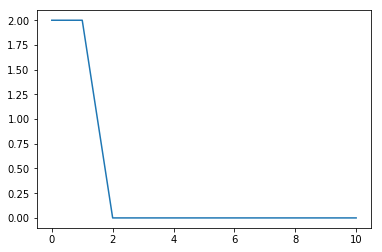

0


In [29]:
#Test the function for one simulation
p_1 = 0.5
p0 = (1-p_1)/3
p1 = (1-p_1)/3
p2 = (1-p_1)/3
n_init = 2

p_i = np.array([p_1, p0, p1, p2])

x = simulate_branching_chain(n_init, p_i, 10)
print(x)

In [30]:
#Test the extinction probbility with 50 simulations of 20 steps
confidence = 0.95
y, int1, int2 = get_prob_extinction(n_init, p_i, 20, 50, confidence)
print("The probability of extinction is: " + str(y) + " with confidence interval at level " + str(confidence*100) + "% : [ " + str(int1)+ ", " + str(int2) + " ]")

The probability of extinction is: 0.84 with confidence interval at level 95.0% : [ 0.7358117119306661, 0.9441882880693339 ]


In [31]:
p_1 = [0.1*(j+1) for j in range(9)]
y = [0 for k in range(9)]
p0 = (1-p_1[1])/3
p1 = (1-p_1[1])/3
p2 = (1-p_1[1])/3
p_i = np.array([p_1[1], p0, p1, p2])
n_init = 2
p_i
x, x1, x2 = get_prob_extinction(n_init, p_i, 20, 10, confidence)

In [32]:
#Compute the extinction probability for different values of the p_1
for i in range(9):
    p0 = (1-p_1[i])/3
    p1 = (1-p_1[i])/3
    p2 = (1-p_1[i])/3
    p_i = np.array([p_1[i], p0, p1, p2])
    n_init = 2
    x, x1, x2 = get_prob_extinction(2, p_i, 20, 10, confidence)
    y[i] = x

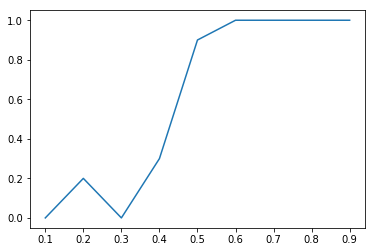

In [33]:
plt.plot(p_1, y)
plt.show()